In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import librosa

In [148]:
import scipy
from scipy import signal
import scipy.io.wavfile
import matplotlib.pyplot as plt
import IPython.display as display

In [149]:
rate, data = scipy.io.wavfile.read("./Data/DataSetSubSet/SetMeFree.wav")
data = data.mean(axis=1)

/Users/pro/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [150]:
stft = STFT()
data_1 = torch.autograd.Variable(torch.FloatTensor(data), requires_grad=False).unsqueeze(0)
output = stft(data_1)

torch.Size([1, 513, 3624])
torch.Size([1, 513, 3624])


In [151]:
# Sxx.shape
display.Audio(data,rate=rate)

In [152]:
output_1 = output[0][0].numpy()
display.Audio(output_1,rate=rate)

In [154]:
print(data.shape[0])

1854291


In [155]:
f, t, Sxx = signal.stft(data,rate,nperseg=1000)
magnitude = np.abs(Sxx)
phase = np.unwrap(np.angle(Sxx),axis=-2)

In [156]:
magnitude_2 = torch.from_numpy(np.expand_dims(magnitude, axis=0))
phase_2 = torch.from_numpy(np.expand_dims(phase, axis=0))
print(magnitude_2.shape)
print(phase_2.shape)

torch.Size([1, 501, 3710])
torch.Size([1, 501, 3710])


In [139]:
stft = STFT(data_1, magnitude_2, phase_2)
test = stft(data_1)

RuntimeError: Given transposed=1, weight of size [1026, 1, 1024], expected input[1, 1002, 3710] to have 1026 channels, but got 1002 channels instead

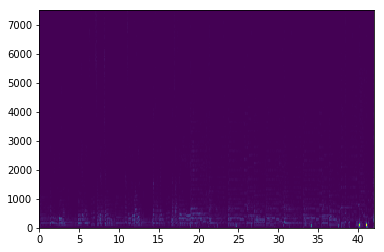

In [12]:
plt.pcolormesh(t,f,magnitude)
plt.ylim([0,7500]);
plt.show()

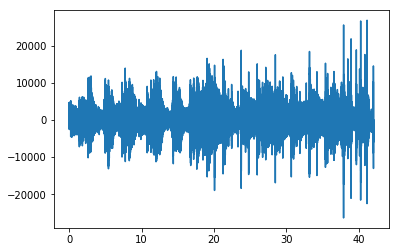

In [13]:
Zxx = magnitude * np.exp(1j * phase)
t2, xrec = signal.istft(Zxx, rate)
plt.plot(t2,xrec);
plt.show()

In [145]:
class STFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=512):
        super(STFT, self).__init__()

        self.filter_length = filter_length
        self.hop_length = hop_length
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])
        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        input_data = input_data.view(num_batches, 1, num_samples)
        forward_transform = F.conv1d(input_data,
                                     Variable(self.forward_basis, requires_grad=False),
                                     stride = self.hop_length,
                                     padding = self.filter_length)
        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(torch.atan2(imag_part.data, real_part.data))
        print(magnitude.shape)
        print(phase.shape)
        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat([magnitude*torch.cos(phase),
                                               magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(recombine_magnitude_phase,
                                               Variable(self.inverse_basis, requires_grad=False),
                                               stride=self.hop_length,
                                               padding=0)
        inverse_transform = inverse_transform[:, :, self.filter_length:]
        inverse_transform = inverse_transform[:, :, :self.num_samples]
        return inverse_transform

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction